# IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd # pandas allows to do a lot of basic data manipulation such as loading csv data files
import matplotlib.pyplot as plt # matplotlib is a basic ploting library of Python
import matplotlib.dates as mdates
import matplotlib.cm as cm

# READ DATA

,prec,ts_0.05,ts_0.15,ts_0.3,ts_0.5,wfps_0.05,wfps_0.15,wfps_0.3,wfps_0.5,lai
timestamp_middle,,,,,,,,,,
2022-08-30,0.8,21.094630,20.312164,19.570266,18.953796,28.194486,22.377460,31.133679,35.603176,1.851371
2022-08-31,6.7,20.214062,20.095393,19.561562,19.005764,29.206998,22.369411,30.947617,35.357119,1.954440
2022-09-01,0.0,18.884595,19.166887,18.992060,18.834410,28.989796,21.929441,30.952053,34.917513,2.056578
2022-09-02,0.0,18.853194,18.740197,18.478854,18.467512,28.276490,21.262119,30.732915,34.631584,2.157315
2022-09-03,2.9,18.898136,18.832847,18.467222,18.307419,27.762098,21.163175,30.535482,34.648147,2.256180
...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.0,15.560579,16.336192,16.185255,16.470370,38.172306,54.743330,53.898561,58.856607,0.000000
2023-10-02,0.0,15.556076,16.109375,15.951343,16.351169,36.981291,54.258860,53.575250,58.710638,0.000000
2023-10-03,0.1,15.828623,16.266586,16.031991,16.304097,35.802015,53.812129,53.340086,58.602586,0.000000


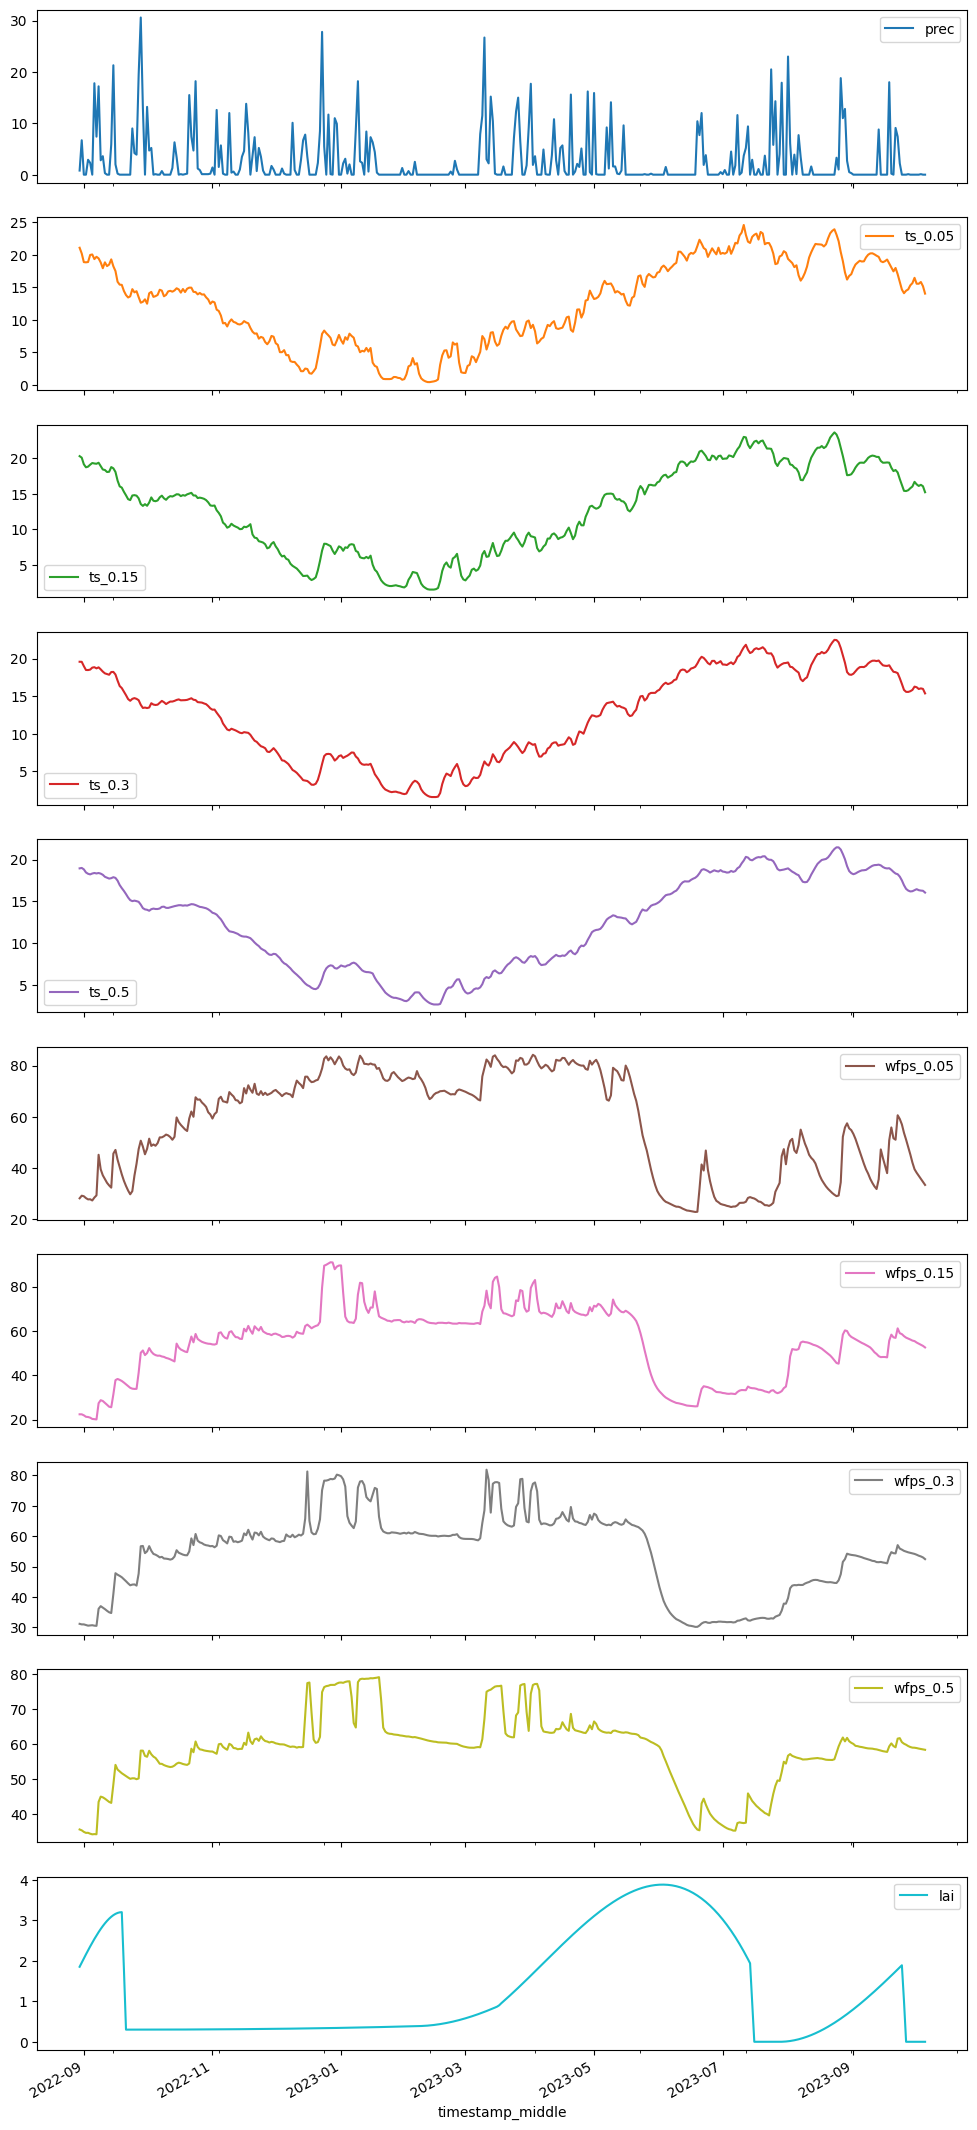

In [2]:
time_resolution = '24' # set time resolution in hours
file_path = '../data/processed/DRIVERS_dataset_' + time_resolution + 'h.csv'
data = pd.read_csv(file_path, low_memory=False)
# Fix column names so all lower case, no spaces or special characters
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
# Fix date to a datetime object
if time_resolution == '24':
    data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'], format='%Y-%m-%d')
else:
    data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'], format='%Y-%m-%d %H:%M:%S')
# Set timestamp as index
data.set_index('timestamp_middle', inplace=True)
# Select columns we are interested in
cols = [c for c in data.columns if ('wfps' in c or 'ts' in c or 'prec' in c or 'lai' in c) and 'diff' not in c and 'lag' not in c and 'roll' not in c and 'timesince' not in c]
data = data[cols]

# Set time interval
start_date = '2022-08-30'
end_date = '2023-10-05'
df = data[start_date:end_date].copy()

df[cols].plot(x_compat=True, subplots=True, figsize=(12, 3*len(cols)));

df

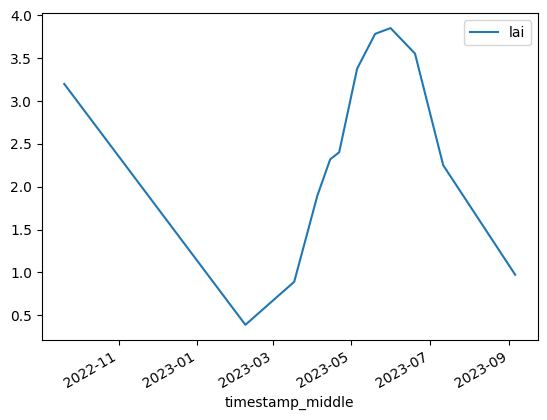

In [4]:
# Import measured LAI values

def process_data(df, date_col, value_col, time_of_day='12:15:00', start_date=None, end_date=None):
    # Convert date column to datetime and create a timestamp
    df['timestamp_middle'] = pd.to_datetime(df[date_col] + f' {time_of_day}', errors='coerce')
    df.set_index('timestamp_middle', inplace=True)
    # Filter by date range if specified
    if start_date and end_date:
        df = df[start_date:end_date]
    # Return the processed dataframe
    return df[[value_col]].copy()

lai = pd.read_csv('../data/raw/LAI_measurements.csv')
lai = process_data(lai, 'date', 'lai', start_date=start_date, end_date=end_date)

lai.plot();

# FIGURE

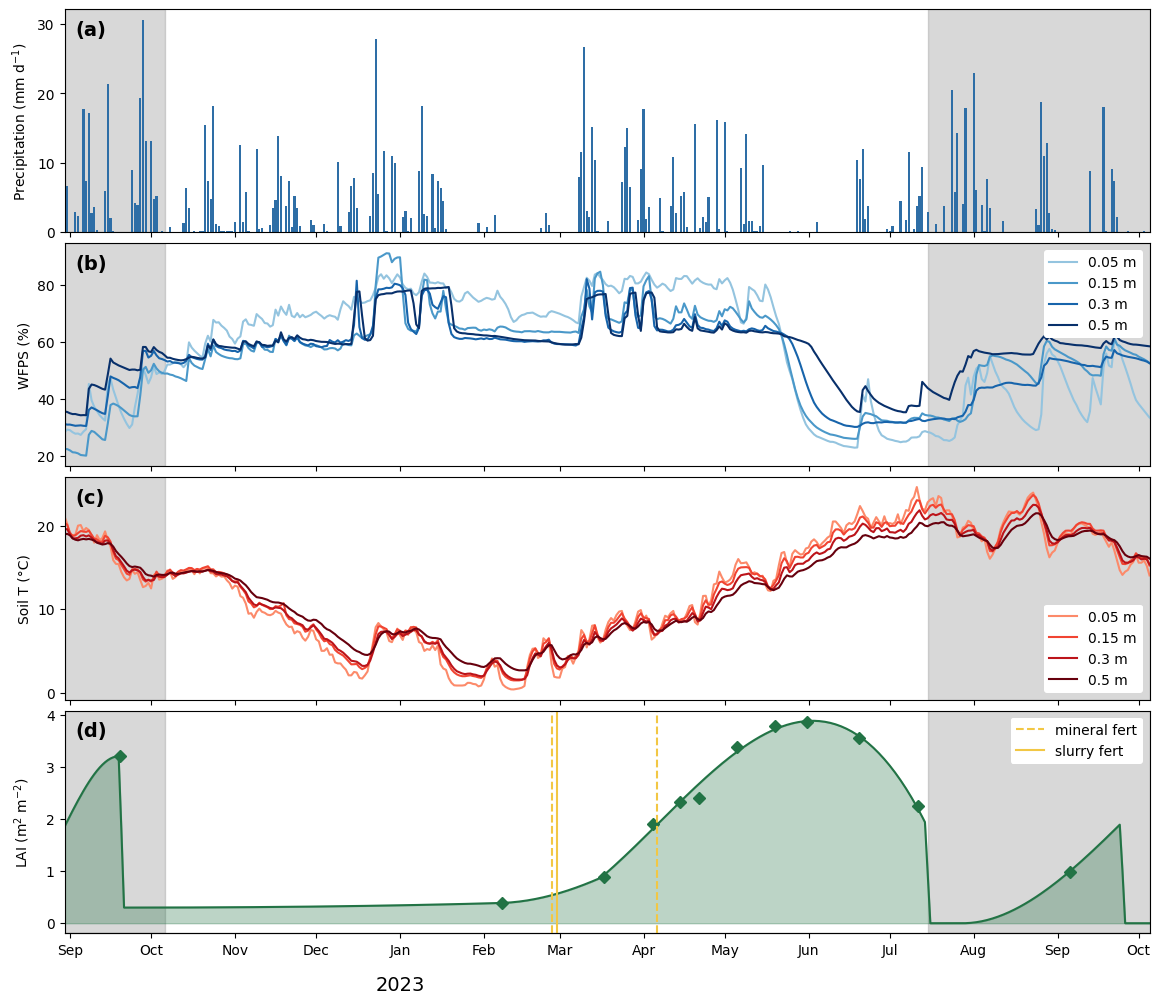

In [5]:
# Define the shading time window
highlight_start = pd.Timestamp('2022-10-06')
highlight_end = pd.Timestamp('2023-07-15')

# Define labels and colors for the management events
color1 = '#003366'
color2 = '#F2C744'
event_lines = [
    {'date': '2023-02-26', 'color': color2, 'linestyle': '--', 'label': 'mineral fert'},
    {'date': '2023-02-28', 'color': color2, 'linestyle': '-', 'label': 'slurry fert'},
    {'date': '2023-04-06', 'color': color2, 'linestyle': '--', 'label': None},  # second mineral fert
]

# Create subplots
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 12))
fig.subplots_adjust(hspace=0.05)  # ← removes vertical spacing
plt.rcParams.update({'font.size': 14})  # Set global font size

########################################################
# Precipitation
ax = axs[0]
x = df.index
y = df['prec'] 
ax.bar(x, y, color="#2E6EA6")
ax.set_ylabel(r'Precipitation (mm d$^{-1}$)')
ax.text(0.01, 0.95, '(a)', transform=ax.transAxes, fontweight='bold', verticalalignment='top')

# Add shading to highlight a certain time window
ax.axvspan(df.index.min(), highlight_start, color='gray', alpha=0.3, zorder=0)
ax.axvspan(highlight_end, df.index.max(), color='gray', alpha=0.3, zorder=0)

#######################################################
# Water filled pore space
ax = axs[1]
incols = [c for c in df.columns if 'wfps' in c]
palette = cm.Blues(np.linspace(0.4, 1, len(incols)))  # Create a range of blues from light to dark
for i, col in enumerate(incols):
    y = df[col]
    label = col.replace('wfps_', '') + ' m'
    ax.plot(x, y, label=label, color=palette[i])
ax.set_ylabel('WFPS (%)')
ax.text(0.01, 0.95, '(b)', transform=ax.transAxes, fontweight='bold', verticalalignment='top')
# Add legend for clarity
legend = ax.legend(loc='upper right', fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(1)  # Ensure the background is fully opaque

# Add shading to highlight a certain time window
ax.axvspan(df.index.min(), highlight_start, color='gray', alpha=0.3, zorder=0)
ax.axvspan(highlight_end, df.index.max(), color='gray', alpha=0.3, zorder=0)

########################################################
# Soil temperature
ax = axs[2]
incols = [c for c in df.columns if 'ts' in c and '0.015' not in c]
palette = cm.Reds(np.linspace(0.4, 1, len(incols)))  # Create a range of blues from light to dark
for i, col in enumerate(incols):
    y = df[col]
    label = col.replace('ts_', '') + ' m'
    ax.plot(x, y, label=label, color=palette[i])
ax.set_ylabel('Soil T (°C)')
ax.text(0.01, 0.95, '(c)', transform=ax.transAxes, fontweight='bold', verticalalignment='top')
# Add legend for clarity
legend = ax.legend(loc='lower right', fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(1)  # Ensure the background is fully opaque

# Add shading to highlight a certain time window
ax.axvspan(df.index.min(), highlight_start, color='gray', alpha=0.3, zorder=0)
ax.axvspan(highlight_end, df.index.max(), color='gray', alpha=0.3, zorder=0)

########################################################
# LAI
ax = axs[3]
x = df.index
y = df['lai'] 
ax.plot(x, y, color="#227345")
ax.fill_between(x, y, color="#227345", alpha=0.3)  # Fill the area below the line
ax.plot(lai.index, lai, color="#227345", marker='D', linestyle='None') # add the measured points
ax.set_ylabel(r'LAI (m$^{2}$ m$^{-2}$)')
ax.text(0.01, 0.95, '(d)', transform=ax.transAxes, fontweight='bold', verticalalignment='top')

# Add fertilization lines
# Plot vertical lines for events
for event in event_lines:
    ax.axvline(pd.to_datetime(event['date']), 
                color=event['color'], 
                linestyle=event['linestyle'], 
                label=event['label'])

# Add legend for clarity
legend = ax.legend(loc='upper right', fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(1)  # Ensure the background is fully opaque

# Add shading to highlight a certain time window
ax.axvspan(df.index.min(), highlight_start, color='gray', alpha=0.3, zorder=0)
ax.axvspan(highlight_end, df.index.max(), color='gray', alpha=0.3, zorder=0)

# Format x-axis for months
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks for months
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as month abbreviation

# Add secondary x-axis for years
secax = axs[-1].secondary_xaxis('bottom')
secax.xaxis.set_major_locator(mdates.YearLocator())  # Year ticks
secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
secax.tick_params(axis='x', length=0, pad=30)  # Add padding for better readability

# Set x-axis limits to match data range --> to prevent white spaces
for ax in axs:
    ax.set_xlim(df.index.min(), df.index.max())

fig.align_ylabels(axs)   # aligns the left y-axis labels vertically

# Save the figure
plt.savefig('../figures/Environmental_drivers.png', dpi=300, bbox_inches='tight')
plt.show()